<a href="https://colab.research.google.com/github/Ogweno/portfolio/blob/main/%22Fraud_Detection_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import os
from tqdm import tqdm

# List of libraries to install
libraries = ['pyspark', '--packages com.databricks:spark-csv_2.10:1.2.0','ppscore', 'findspark', 'rpy2']

# Install libraries in silence
for lib in tqdm(libraries, desc="Installing libraries", unit="library"):
    os.system(f"pip install {lib} -q")

Installing libraries: 100%|██████████| 5/5 [00:33<00:00,  6.76s/library]


In [7]:
!pip install -q --upgrade --force-reinstall --no-deps kaggle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [139]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Fraud Detection Using pyspark ")\
        .config('spark.ui.port', '4050')\
        .config("spark.executor.memory", "8g") \
        .getOrCreate()

In [140]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pyspark.sql.functions as F
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import mean, stddev, format_number, col, countDistinct
from py4j.protocol import Py4JJavaError

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.util import MLUtils

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve, auc, precision_recall_curve, log_loss, mean_squared_error, mean_absolute_error, matthews_corrcoef, cohen_kappa_score

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# Get the Kaggle secret Key

In [9]:
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle datasets

In [10]:
! kaggle datasets download mlg-ulb/creditcardfraud

 85% 56.0M/66.0M [00:00<00:00, 113MB/s] 
100% 66.0M/66.0M [00:00<00:00, 112MB/s]


## Unzip the downloaded dataset

In [11]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


# View the dataset

In [12]:
#!wget -q https://www.kaggle.com/arockiaselciaa/creditcard.csv
df = spark.read.csv('/content/creditcard.csv',header=True,inferSchema=True)
df.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

# Exploration of Data

In [27]:
def find_binary_columns(dataframe):
    binary_columns = []
    non_binary_columns = []

    for column in dataframe.columns:
        distinct_count = dataframe.select(countDistinct(column)).first()[0]
        if distinct_count == 2:
            binary_columns.append(column)
        else:
            non_binary_columns.append(column)

    return binary_columns, non_binary_columns

# Example usage:
# Assuming 'df' is your DataFrame
binary_cols, non_binary_cols = find_binary_columns(df)
print("Binary Columns:", binary_cols)
print("Non-Binary Columns:", non_binary_cols)

Binary Columns: ['Class']
Non-Binary Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


########## Schema #############
root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable

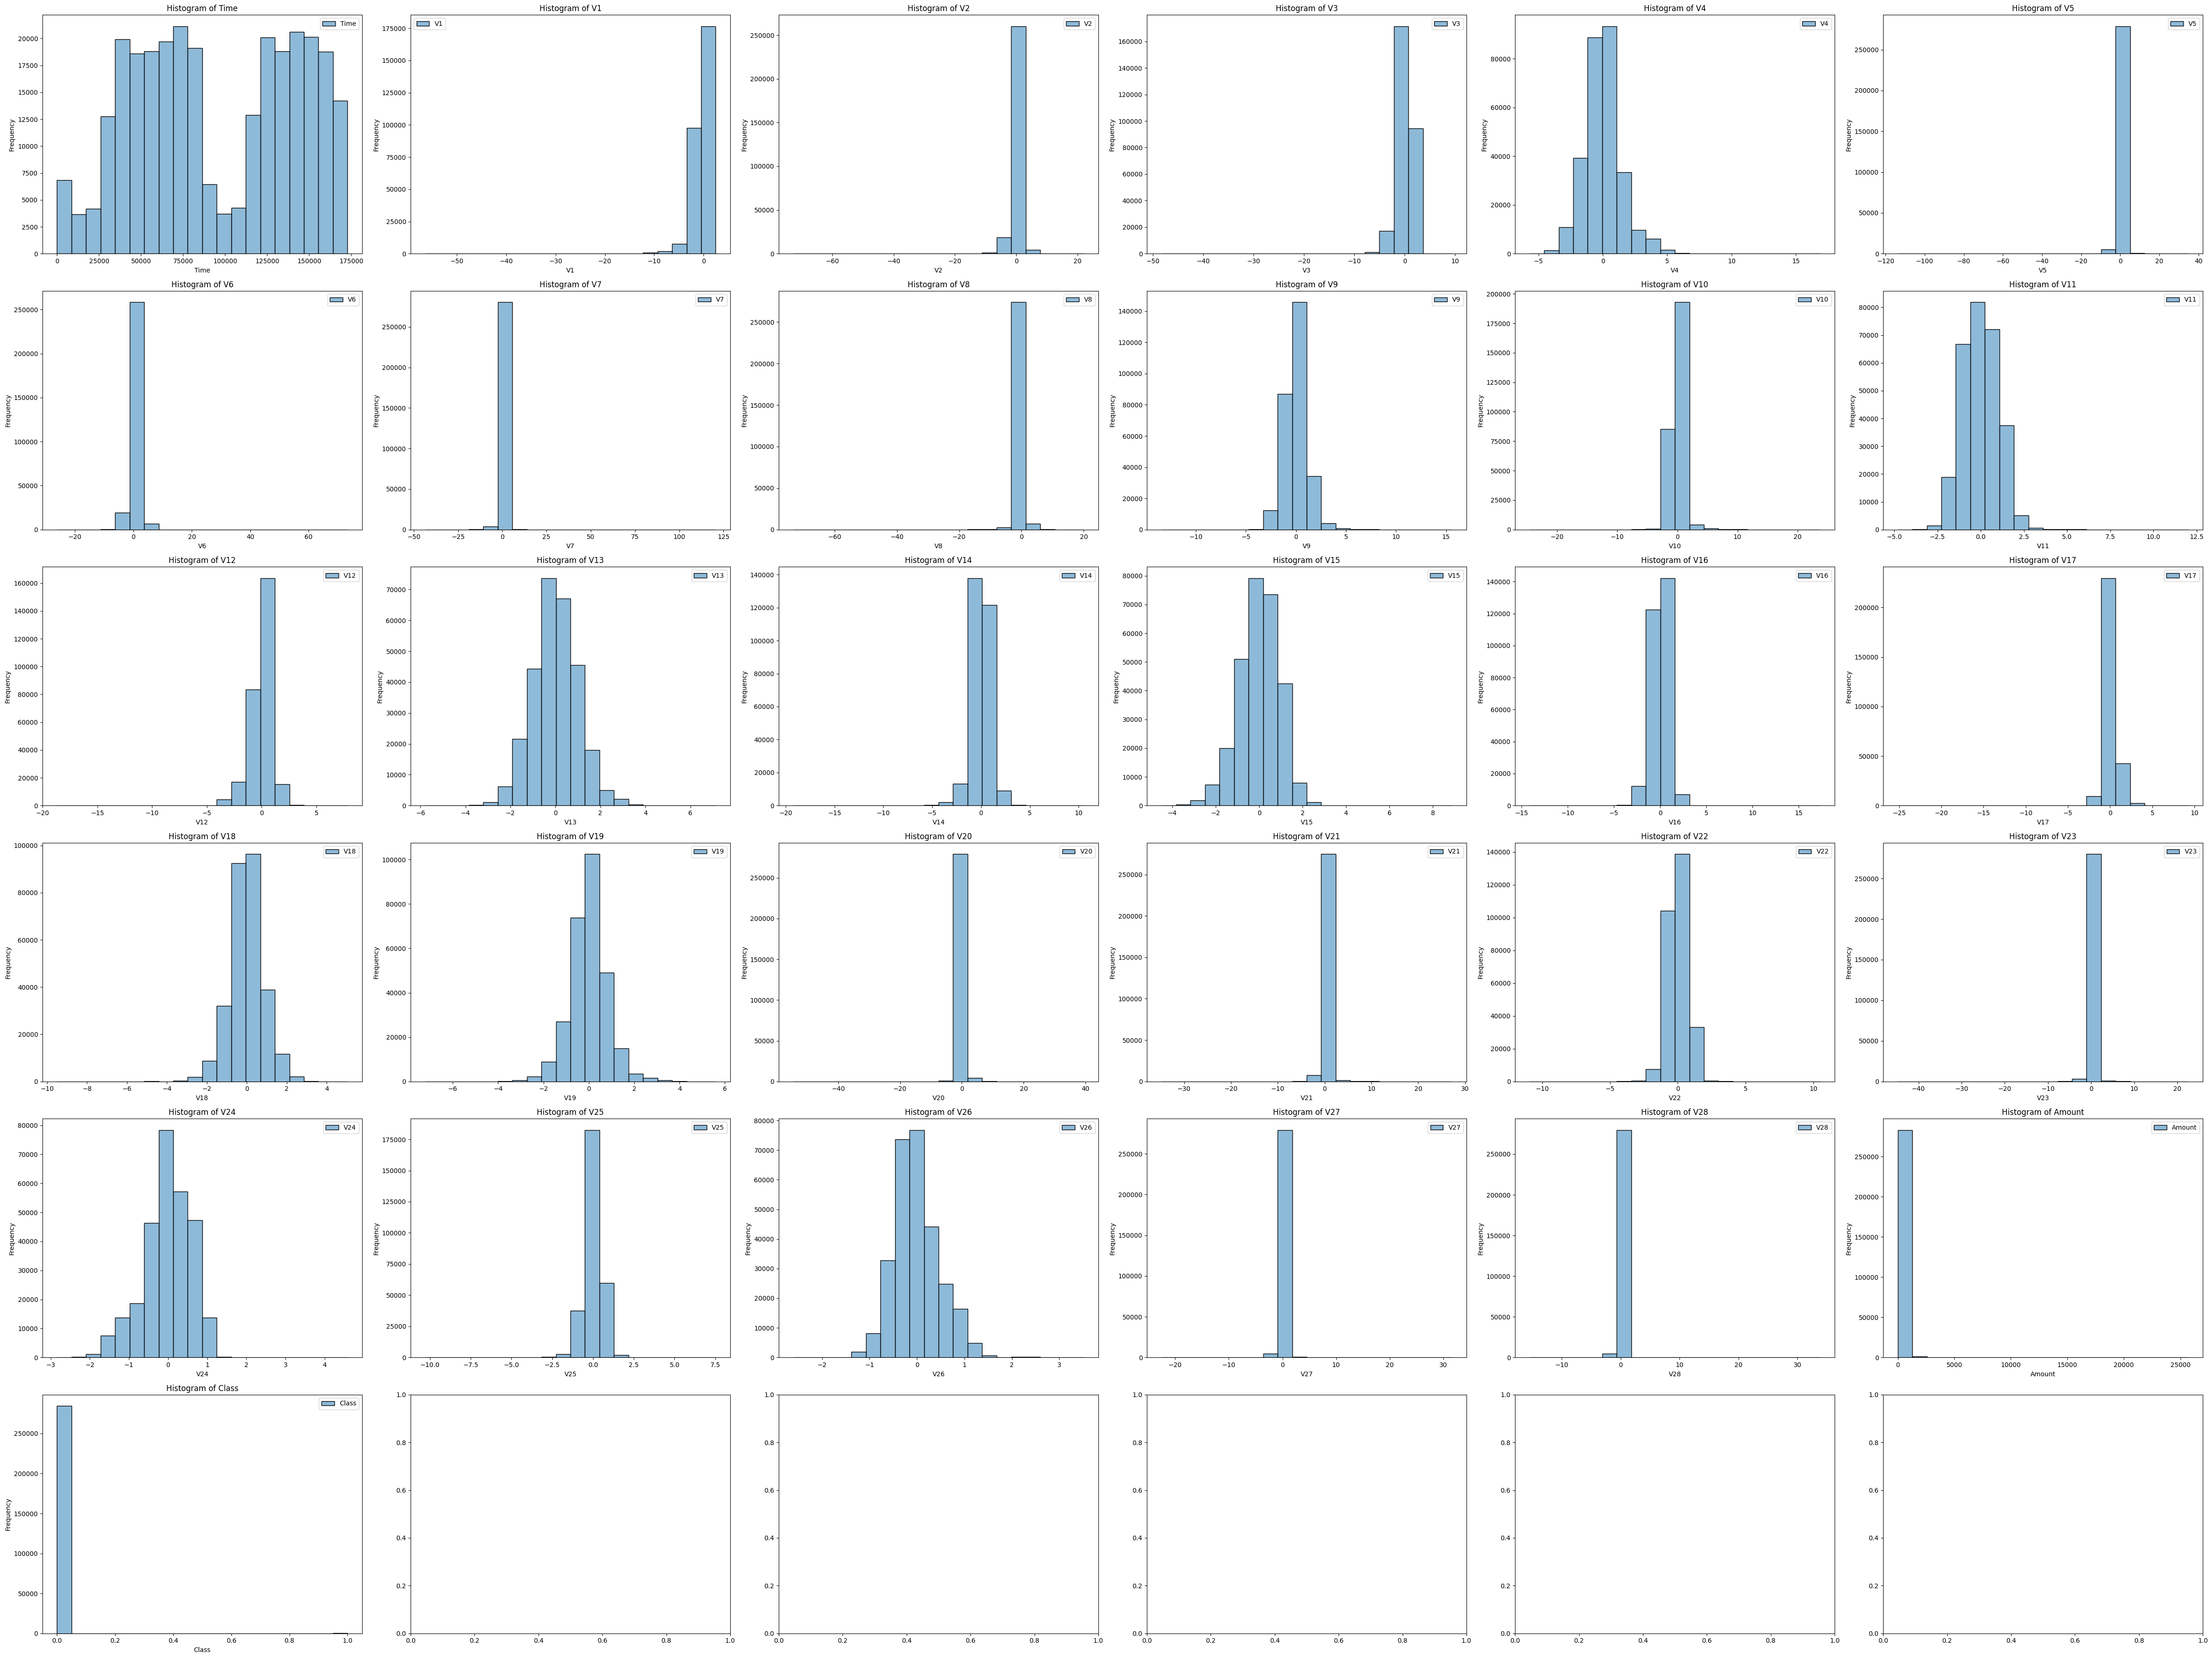


########## Distribution of Categorical Attributes #############


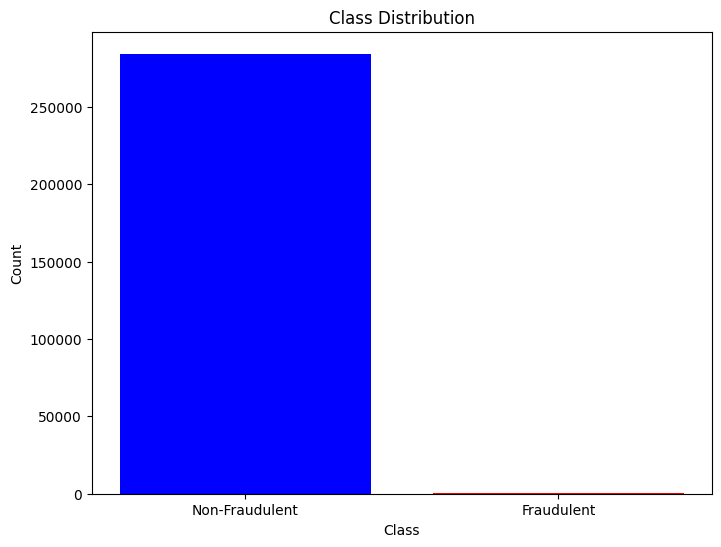

In [38]:
def check_df(dataframe, head=5):
    # Schema
    print("########## Schema #############")
    print(dataframe.printSchema())

    # Summary Statistics
    print("\n########## Summary Statistics #############")
    dataframe_summary = dataframe.summary().toPandas()
    dataframe_summary = dataframe_summary.rename(index={'summary': 'Statistics'})
    print(tabulate(dataframe_summary, headers='keys', tablefmt='psql'))

    # Head of Data
    print("\n########## Head of Data #############")
    print(tabulate(dataframe.limit(head).toPandas(), headers='keys', tablefmt='psql'))

    # Tail of Data
    print("\n########## Tail of Data #############")
    print(tabulate(dataframe.tail(head), headers='keys', tablefmt='psql', showindex=False))

    # Null Values
    print("\n########## Null Values of Data #############")
    null_counts = dataframe.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in dataframe.columns]).collect()[0].asDict()
    null_data = [{'Column': column, 'Null Count': count} for column, count in null_counts.items()]
    print(tabulate(null_data, headers='keys', tablefmt='psql'))

    # Describe of the Numerical Data
    print("\n########## Describe of the Numerical Data #############")
    numerical_summary = dataframe.describe().toPandas()
    numerical_summary = numerical_summary.rename(index={'summary': 'Statistics'})
    print(tabulate(numerical_summary, headers='keys', tablefmt='psql'))

    # Find Unique Values
    print("\n########## Unique Values #############")
    unique_counts = dataframe.select([countDistinct(c).alias(c) for c in dataframe.columns]).collect()[0].asDict()
    unique_data = [{'Column': column, 'Unique Count': count} for column, count in unique_counts.items()]
    print(tabulate(unique_data, headers='keys', tablefmt='psql'))

    # Separate Attributes into Numeric and Categorical
    numeric_cols = [col_name for col_name, data_type in dataframe.dtypes if data_type != "string"]
    categorical_cols = [col_name for col_name, data_type in dataframe.dtypes if data_type == "string"]

    # Plot Distribution of Numeric Attributes
    print("\n########## Distribution of Numeric Attributes #############")
    num_cols_count = len(numeric_cols)
    num_rows = (num_cols_count + 5) // 6  # Calculate number of rows for subplots
    fig, axes = plt.subplots(num_rows, 6, figsize=(8*num_rows, 6*num_rows))

    for i, col in enumerate(numeric_cols):
        ax = axes[i // 6, i % 6]  # Get current axis
        sns.histplot(dataframe.select(col).toPandas(), bins=20, color='blue', ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Plot Distribution of Categorical Attributes
    print("\n########## Distribution of Categorical Attributes #############")
    for col in categorical_cols:
        plt.figure(figsize=(8, 6))
        cat_distribution = dataframe.groupBy(col).count().toPandas()
        labels = cat_distribution[col].apply(lambda x: f"{x}: {cat_distribution[cat_distribution[col] == x]['count'].values[0]}")
        plt.pie(cat_distribution['count'], labels=labels, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')
        plt.title(f'Distribution of {col}')
        plt.show()

    # Check the number of occurrences of each class label and plot the information
    non_fraud = dataframe.filter(dataframe.Class == 0)
    fraud = dataframe.filter(dataframe.Class == 1)

    class_labels = ['Non-Fraudulent', 'Fraudulent']
    class_counts = [non_fraud.count(), fraud.count()]

    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, class_counts, color=['blue', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

# Assuming 'df' is your DataFrame
check_df(df)


# Variable Importance using recursive feature elimination (rfe)

In [121]:
# Drop the existing "scaled_features" column if it exists
if "scaled_features" in df.columns:
    df = df.drop("scaled_features")

# Assemble features
feature_cols = df.columns[:-1]  # Exclude the target column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_tmp_0")
df = assembler.transform(df)

# Scale features
scaler = StandardScaler(inputCol="features_tmp_0", outputCol="scaled_features", withStd=True, withMean=False)
df = scaler.fit(df).transform(df)

# Initialize Random Forest classifier
rf = RandomForestClassifier(labelCol="Class", featuresCol="scaled_features", seed=42)

# Create an empty list to hold selected features
selected_features = []

# Number of features to select
num_features_to_select = 10

# Perform RFE
for i in range(num_features_to_select):
    # Train Random Forest model
    rf_model = rf.fit(df)

    # Get feature importances
    feature_importances = rf_model.featureImportances

    # Convert SparseVector to DenseVector and find the index of the minimum value
    min_importance_idx = feature_importances.toArray().argmin()

    # Add the selected feature to the list
    selected_features.append(feature_cols[min_importance_idx])

    # Remove the selected feature from the dataset
    feature_cols.remove(selected_features[-1])
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_tmp_" + str(i+1))
    df = assembler.transform(df).drop("features_tmp_" + str(i)).withColumnRenamed("features_tmp_" + str(i+1), "features_tmp_0")

In [122]:
# Print selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)

Selected Features:
Time
V1
V2
V3
V4
V5
V6
V7
V8
V9


In [126]:
print("Length of feature names:", len(feature_names))
print("Length of feature importances:", len(feature_importances))


Length of feature names: 44
Length of feature importances: 92


In [125]:
# Get feature importances
feature_importances = rf_model.featureImportances.toArray()

# Get feature names
feature_names = df.columns[:-1]

print("Number of features:", len(feature_names))

# Sort features by importance and select top 10
sorted_indices = feature_importances.argsort()[::-1][:10]
print("Sorted indices:", sorted_indices)
selected_features = [feature_names[i] for i in sorted_indices]
importance_scores = [feature_importances[i] for i in sorted_indices]


# Plotting the importance of selected features
plt.figure(figsize=(10, 6))
plt.barh(selected_features, importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 10 Selected Features Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

Number of features: 44
Sorted indices: [91 30 48 38 45 78 43 68 16 64]


IndexError: list index out of range

# Fixing data imbalance
Create two functions: *balance_classes* to balance the classes and *plot_class_distribution* to plot the distribution of classes.

* The balance_classes function takes a DataFrame, and optionally allows specifying the class column, sample size, and random state.
* The plot_class_distribution function takes the balanced DataFrame and plots the distribution of classes.

In [32]:
def balance_classes(dataframe, class_column='Class', sample_size=None, random_state=None):
    # Convert PySpark DataFrame to Pandas DataFrame
    data = dataframe.toPandas()

    # Shuffle the DataFrame
    data = data.sample(frac=1, random_state=random_state)

    # Determine the sample size
    if sample_size is None:
        sample_size = min(data[class_column].value_counts())

    # Extract fraud and non-fraud classes
    fraud_df = data.loc[data[class_column] == 1]
    non_fraud_df = data.loc[data[class_column] == 0][:sample_size]

    # Concatenate fraud and non-fraud classes
    balanced_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle the balanced DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=random_state)

    return balanced_df

def plot_class_distribution(dataframe, class_column='Class'):
    # Print class distribution
    print('Distribution of the Classes in the subsample dataset:')
    print(dataframe[class_column].value_counts() / len(dataframe))

    # Plot class distribution
    plt.figure(figsize=(5, 4))
    sns.countplot(x=class_column, data=dataframe)  # Specify 'x' parameter explicitly
    plt.title('Equally Distributed Classes', fontsize=14)
    plt.savefig('Figures_fraud/Fraud_dist_sampled.jpg')
    plt.show()

In [34]:
'''Check if directory exists, if not, create it'''
import os
# You should change 'images' to your preferred folder.
MYDIR = ("Figures_fraud")
CHECK_FOLDER = os.path.isdir(MYDIR)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR)
    print("created folder : ", MYDIR)

else:
    print(MYDIR, "folder already exists.")

created folder :  Figures_fraud


Distribution of the Classes in the subsample dataset:
0    0.5
1    0.5
Name: Class, dtype: float64


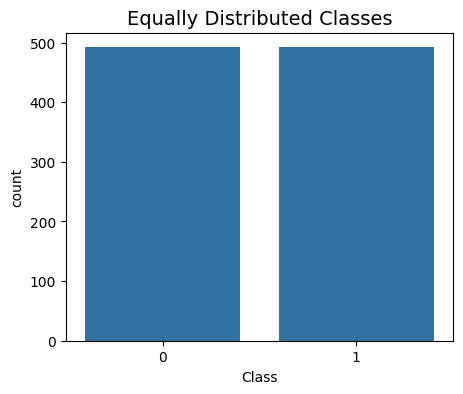

In [35]:
# Assuming 'df' is your DataFrame
balanced_df = balance_classes(df)
plot_class_distribution(balanced_df)

In [43]:
#Lets apply scaling techniques on the Amount feature to transform the range of values. We drop the original Amount column and add a new column with the scaled values. We also drop the Time column as it is irrelevant.
#First Step in PySpark is Make Vector of the Values in Amount Column
def scale_and_remove_columns(dataframe, input_col="Amount", output_col="SAmount", drop_cols=["Amount", "Amount_Vect", "Time"]):
    # Step 1: Make Vector of the Values in Amount Column
    assembler = VectorAssembler(inputCols=[input_col], outputCol="Amount_Vect")
    output = assembler.transform(dataframe)
    output.show(5)

    # Step 2: Apply Scaling on it
    scaler = StandardScaler(inputCol="Amount_Vect", outputCol=output_col, withStd=True, withMean=False)
    final_df = scaler.fit(output).transform(output)
    final_df.show(5)

    # Step 3: Remove unwanted columns
    final_df = final_df.drop(*drop_cols)
    final_df.show(5)

    return final_df

# Convert Pandas DataFrame to PySpark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

# Call the function with the PySpark DataFrame
scaled_removed_df = scale_and_remove_columns(balanced_spark_df)


+--------+-----------------+-------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+-----------------+-------------------+--------------------+------+-----+-----------+
|    Time|               V1|                 V2|                V3|               V4|                V5|                V6|                V7|                 V8|               V9|               V10|               V11|              V12|               V13|              V14|               V15|               V16|               V17|                V18|               V19|                V20|                V21|               V22| 

In [49]:
def prepare_features(dataframe, numericCols, binaryCol):
    # Exclude the binary column from the numeric columns
    numericCols = [col for col in numericCols if col != binaryCol]

    # VectorAssembler to combine numeric features into a single vector
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
    output = assembler.transform(dataframe)

    # Select only the features and the binary column
    selectedCols = ["features", binaryCol]
    return output.select(selectedCols)


selectedNumericCols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
binaryCol = 'Class'

# Convert Pandas DataFrame to PySpark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

mdf = prepare_features(balanced_spark_df, selectedNumericCols, binaryCol)
mdf.show(5)


+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[1.19316502134287...|    0|
|[-1.6492788161135...|    1|
|[-1.6118773376336...|    1|
|[-8.3317523750345...|    0|
|[-14.474437492486...|    1|
+--------------------+-----+
only showing top 5 rows



In [84]:
def prepare_features(dataframe, numericCols, targetCol):
    from pyspark.ml.feature import VectorAssembler, StandardScaler

    # Assemble the numeric columns into a features vector
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
    mdf = assembler.transform(dataframe)

    # Scale numeric features between -1 and 1
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
    scaler_model = scaler.fit(mdf)
    mdf = scaler_model.transform(mdf).drop("features").withColumnRenamed("scaled_features", "features")

    # Rename the target column
    mdf = mdf.withColumnRenamed(targetCol, "label")

    # Print the counts of training and test datasets
    train, test = mdf.randomSplit([0.7, 0.3], seed=2018)
    print("Training Dataset Count: " + str(train.count()))
    print("Test Dataset Count: " + str(test.count()))

    return mdf





In [66]:
# Assuming selectedNumericCols is defined
selectedNumericCols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
targetCol = "Class"

balanced_spark_df = spark.createDataFrame(balanced_df)

# Call the prepare_features function
mdf = prepare_features(balanced_spark_df, selectedNumericCols, targetCol)

# Split the data into train and test sets
train, test = mdf.randomSplit([0.7, 0.3], seed=2018)


Training Dataset Count: 704
Test Dataset Count: 280


# Model Evaluation Metrics for Machine Learning

In classification problems, we use two types of algorithms (dependent on the kind of output it creates):

* Class output: Algorithms like SVM and KNN create a class output. For instance, in a binary classification problem, the outputs will be either 0 or 1. However, today we have algorithms that can convert these class outputs to probability. But these algorithms are not well accepted by the statistics community.
* Probability output: Algorithms like Logistic Regression, Random Forest, Gradient Boosting, Adaboost, etc., give probability outputs. Converting probability outputs to class output is just a matter of creating a threshold probability.

A few definition of the confusion matrix can be seen in the figure below

![](https://www.analyticsvidhya.com/blog/wp-content/uploads/2015/01/Confusion_matrix.png)

# Mathematical expressions


The most commonly used evaluation metrics for binary classification are accuracy, sensitivity, specificity, and precision, which express the percentage of correctly classified instances in the set of all the instances, the truly positive instances, the truly negative instances, or the instances classified as positive, respectively.


\begin{aligned} \mathrm{Acc.}&=\frac{\textrm{TP}+\textrm{TN}}{\textrm{TP}+\textrm{TN}+\textrm{FP}+\textrm{FN}}\in [0,1],\quad \mathrm{Sen.}=\mathrm{Rec.}=\frac{\textrm{TP}}{\textrm{TP}+\textrm{FN}}\in [0,1],\\ \mathrm{Spe.}&=\frac{\textrm{TN}}{\textrm{TN}+\textrm{FP}}\in [0,1],\quad \mathrm{Pre.}=\frac{\textrm{TP}}{\textrm{TP}+\textrm{FP}}\in [0,1], \end{aligned} \end{aligned}

## F1-Score
\begin{aligned} \textrm{F1}=\frac{2\cdot \mathrm{Pre.}\cdot \mathrm{Rec.}}{\mathrm{Pre.}+\mathrm{Rec.}}\in [0,1], \end{aligned}

## Cohen’s kappa
\begin{aligned} \kappa =\frac{\mathrm{Acc.}-p_e}{1-p_e}\in (-\infty ,1]\quad \text {with}\quad p_e=\frac{(\textrm{TP}+\textrm{FN})(\textrm{TP}+\textrm{FP})+(\textrm{TN}+\textrm{FP})(\textrm{TN}+\textrm{FN})}{(\textrm{TP}+\textrm{TN}+\textrm{FP}+\textrm{FN})^2} \end{aligned}

## Matthews’ correlation coefficient (MCC), defined as

\begin{aligned} \textrm{MCC}=\frac{\textrm{TN}\cdot \textrm{TP}-\textrm{FN}\cdot \textrm{FP}}{\sqrt{(\textrm{TP}+\textrm{FP})(\textrm{TP}+\textrm{FN})(\textrm{TN}+\textrm{FP})(\textrm{TN}+\textrm{FN})}}\in [-1,1], \end{aligned}

## cross-entropy loss defined as

\begin{aligned} H(p,q)=-\sum ^n_{i=1}p_i\log (q_i). \end{aligned}


In [174]:
def evaluate_model(model, train, test, model_name):
    # Fit the model on the training data
    model_fit = model.fit(train)

    # Make predictions on the test data
    predictions = model_fit.transform(test)

    # Evaluate the model's performance
    evaluator_multiclass = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy = evaluator_multiclass.evaluate(predictions, {evaluator_multiclass.metricName: "accuracy"})

    evaluator_binary = BinaryClassificationEvaluator(labelCol="label")
    auc_score = evaluator_binary.evaluate(predictions)

    # Calculate confusion matrix
    preds_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
    metrics = MulticlassMetrics(preds_and_labels)
    cm = metrics.confusionMatrix().toArray()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot ROC curve if 'probability' column exists
    if 'probability' in predictions.columns:
        y_test = [row.label for row in predictions.select("label").collect()]
        y_score = [row.probability[1] for row in predictions.select("probability").collect()]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    # Calculate additional metrics
    precision, recall, f1_score_non_fraud, f1_score_fraud = None, None, None, None
    logloss, mse, mae, mcc, kappa = None, None, None, None, None

    if 'probability' in predictions.columns:
        y_score = [row.probability[1] for row in predictions.select("probability").collect()]
        y_test = [row.label for row in predictions.select("label").collect()]
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        logloss = log_loss(y_test, y_score)
        mse = mean_squared_error(y_test, y_score)
        mae = mean_absolute_error(y_test, y_score)
        mcc = matthews_corrcoef(y_test, [1 if val > 0.5 else 0 for val in y_score])
        kappa = cohen_kappa_score(y_test, [1 if val > 0.5 else 0 for val in y_score])
        f1_score_non_fraud = metrics.fMeasure(0.0)
        f1_score_fraud = metrics.fMeasure(1.0)

    # Print metrics in a table format
    print(f"Metrics for {model_name}:")
    metrics_table = [
        ["Accuracy", round(accuracy, 2)],
        ["AUC", round(auc_score, 2)],
        ["Precision (Non-Fraud)", round(precision[0], 2) if precision is not None else None],
        ["Precision (Fraud)", round(precision[1], 2) if precision is not None else None],
        ["Recall (Non-Fraud)", round(recall[0], 2) if recall is not None else None],
        ["Recall (Fraud)", round(recall[1], 2) if recall is not None else None],
        ["F1-score (Non-Fraud)", round(f1_score_non_fraud, 2) if f1_score_non_fraud is not None else None],
        ["F1-score (Fraud)", round(f1_score_fraud, 2) if f1_score_fraud is not None else None],
        ["Log Loss", round(logloss, 2) if logloss is not None else None],
        ["Mean Squared Error", round(mse, 2) if mse is not None else None],
        ["Mean Absolute Error", round(mae, 2) if mae is not None else None],
        ["Matthews Correlation Coefficient", round(mcc, 2) if mcc is not None else None],
        ["Cohen's Kappa", round(kappa, 2) if kappa is not None else None]
    ]
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

#

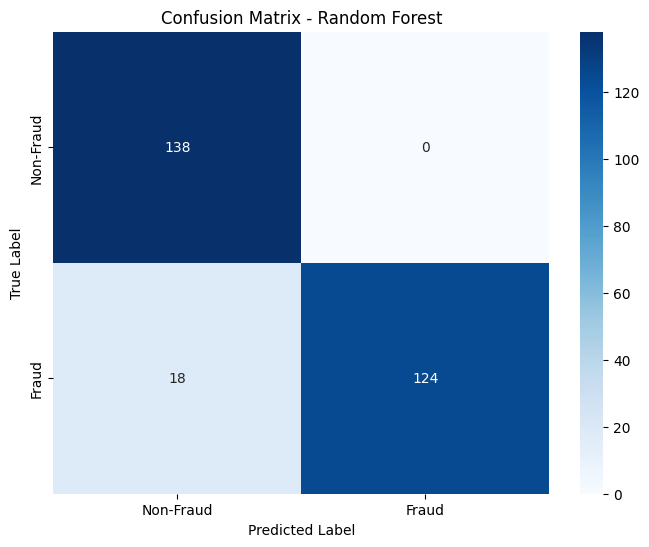

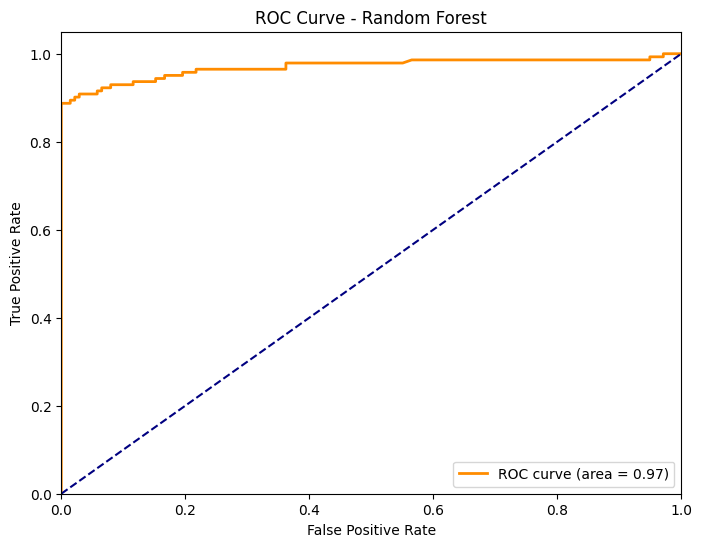

Metrics for Random Forest:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Accuracy                         |    0.94 |
+----------------------------------+---------+
| AUC                              |    0.97 |
+----------------------------------+---------+
| Precision (Non-Fraud)            |    0.51 |
+----------------------------------+---------+
| Precision (Fraud)                |    0.51 |
+----------------------------------+---------+
| Recall (Non-Fraud)               |    1    |
+----------------------------------+---------+
| Recall (Fraud)                   |    1    |
+----------------------------------+---------+
| F1-score (Non-Fraud)             |    0.94 |
+----------------------------------+---------+
| F1-score (Fraud)                 |    0.93 |
+----------------------------------+---------+
| Log Loss                         |    0.18 |
+--------------------------------

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


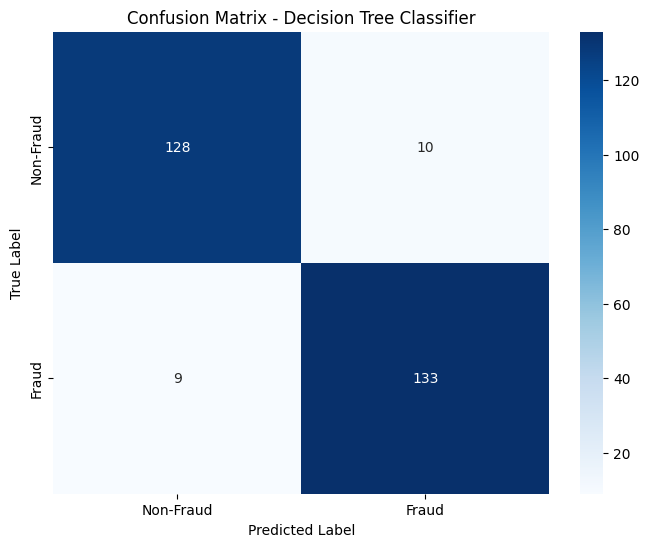

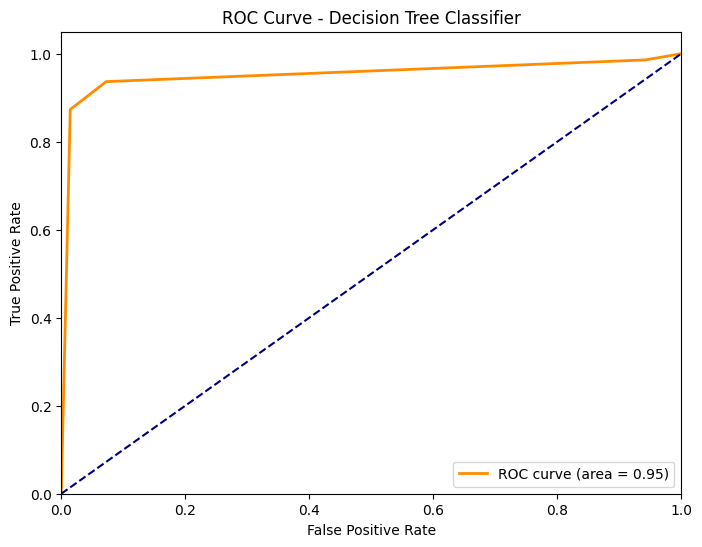

Metrics for Decision Tree Classifier:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Accuracy                         |    0.93 |
+----------------------------------+---------+
| AUC                              |    0.9  |
+----------------------------------+---------+
| Precision (Non-Fraud)            |    0.51 |
+----------------------------------+---------+
| Precision (Fraud)                |    0.52 |
+----------------------------------+---------+
| Recall (Non-Fraud)               |    1    |
+----------------------------------+---------+
| Recall (Fraud)                   |    0.99 |
+----------------------------------+---------+
| F1-score (Non-Fraud)             |    0.93 |
+----------------------------------+---------+
| F1-score (Fraud)                 |    0.93 |
+----------------------------------+---------+
| Log Loss                         |    0.44 |
+---------------------

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


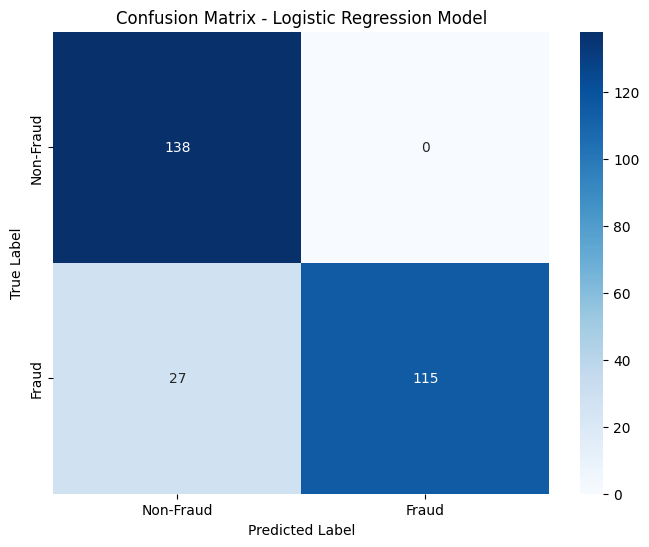

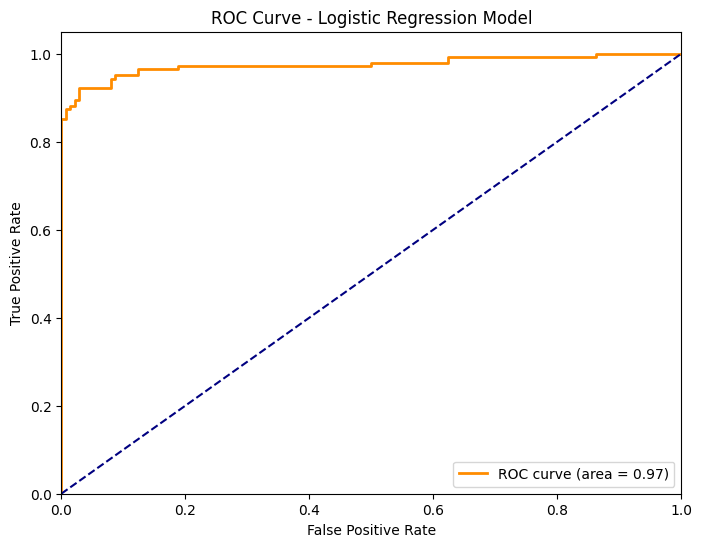

Metrics for Logistic Regression Model:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Accuracy                         |    0.9  |
+----------------------------------+---------+
| AUC                              |    0.97 |
+----------------------------------+---------+
| Precision (Non-Fraud)            |    0.51 |
+----------------------------------+---------+
| Precision (Fraud)                |    0.51 |
+----------------------------------+---------+
| Recall (Non-Fraud)               |    1    |
+----------------------------------+---------+
| Recall (Fraud)                   |    1    |
+----------------------------------+---------+
| F1-score (Non-Fraud)             |    0.91 |
+----------------------------------+---------+
| F1-score (Fraud)                 |    0.89 |
+----------------------------------+---------+
| Log Loss                         |    0.54 |
+--------------------

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


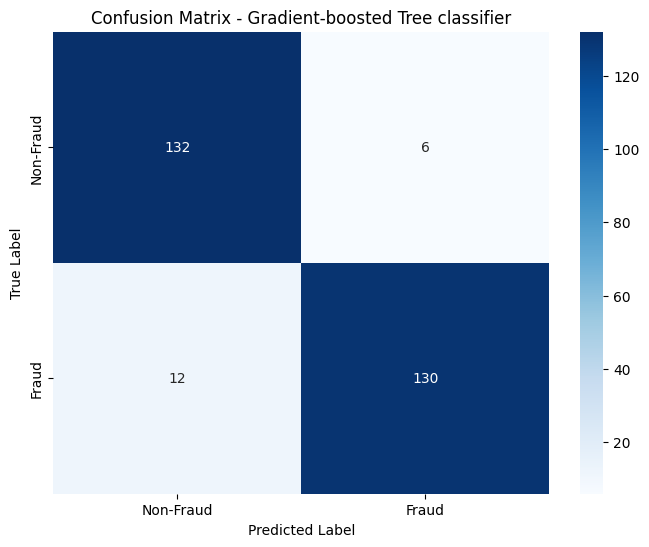

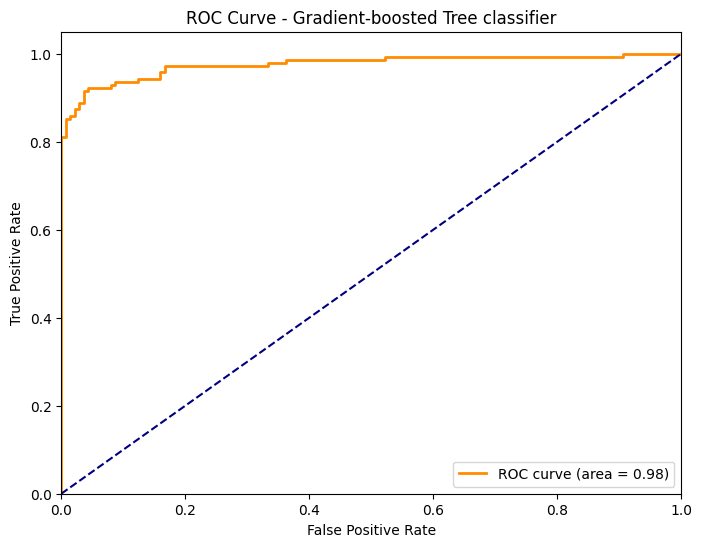

Metrics for Gradient-boosted Tree classifier:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Accuracy                         |    0.94 |
+----------------------------------+---------+
| AUC                              |    0.98 |
+----------------------------------+---------+
| Precision (Non-Fraud)            |    0.51 |
+----------------------------------+---------+
| Precision (Fraud)                |    0.51 |
+----------------------------------+---------+
| Recall (Non-Fraud)               |    1    |
+----------------------------------+---------+
| Recall (Fraud)                   |    1    |
+----------------------------------+---------+
| F1-score (Non-Fraud)             |    0.94 |
+----------------------------------+---------+
| F1-score (Fraud)                 |    0.94 |
+----------------------------------+---------+
| Log Loss                         |    0.2  |
+-------------

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


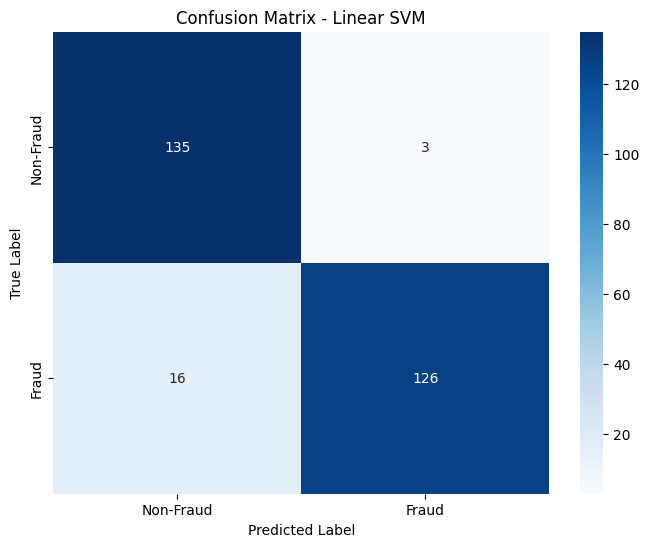

Metrics for Linear SVM:
+----------------------------------+---------+
| Metric                           |   Value |
+==================================+=========+
| Accuracy                         |    0.93 |
+----------------------------------+---------+
| AUC                              |    0.97 |
+----------------------------------+---------+
| Precision (Non-Fraud)            |         |
+----------------------------------+---------+
| Precision (Fraud)                |         |
+----------------------------------+---------+
| Recall (Non-Fraud)               |         |
+----------------------------------+---------+
| Recall (Fraud)                   |         |
+----------------------------------+---------+
| F1-score (Non-Fraud)             |         |
+----------------------------------+---------+
| F1-score (Fraud)                 |         |
+----------------------------------+---------+
| Log Loss                         |         |
+----------------------------------+

In [175]:
# Example usage:
models_to_evaluate = [
    (RandomForestClassifier(featuresCol='features', labelCol='label'), "Random Forest"),
    (DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3), 'Decision Tree Classifier'),
    (LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8),'Logistic Regression Model'),
    (GBTClassifier(labelCol='label', featuresCol='features'),'Gradient-boosted Tree classifier'),
    #(NaiveBayes(labelCol='label', featuresCol='features'),'Naive Bayes'),
    (LinearSVC(labelCol='label', featuresCol='features'),'Linear SVM')
]

for model, name in models_to_evaluate:
    evaluate_model(model, train, test, name)